In [2]:
from bankingSystem import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings 
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 20)
pylab.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


### model without the exogeous shock

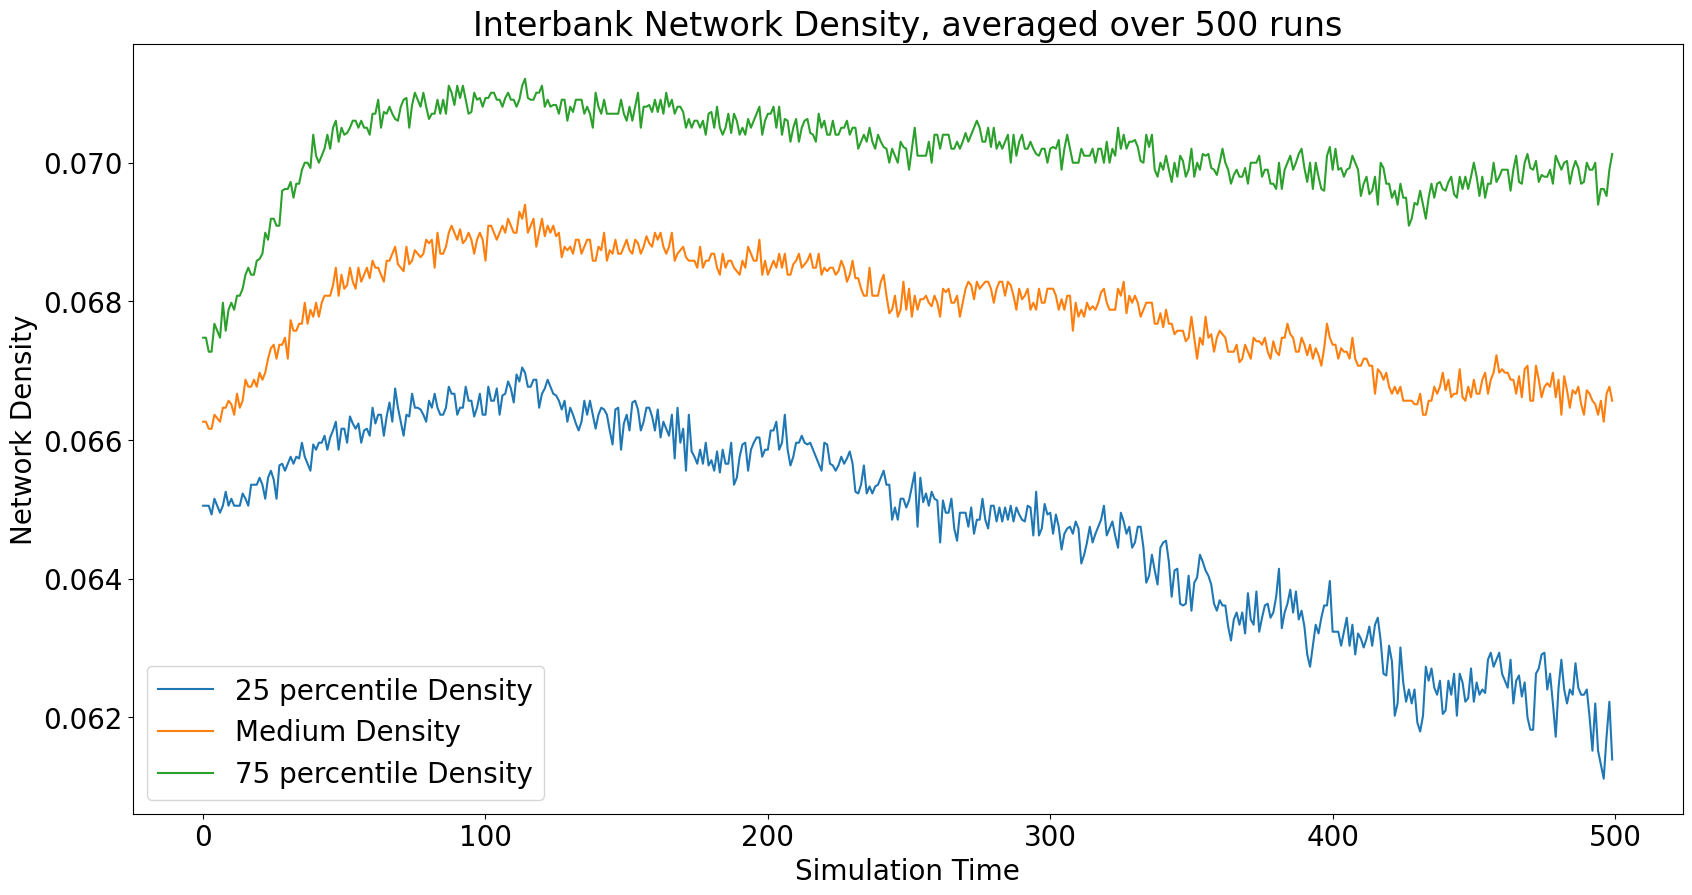

In [99]:
# network density distribution
DensityCollection = []
for i in range(500):
    m,_ = results[i]
    DensityCollection.append([(m["Liability Matrix"][j]>0).sum()/(100*99) for j in range(simulationSteps)])
DensityCollection = np.array(DensityCollection)
plt.figure(figsize=(20,10))
plt.title("Interbank Network Density, averaged over 500 runs")
plt.plot(range(simulationSteps),np.percentile(DensityCollection, 25, axis=0), label="25 percentile Density")
plt.plot(range(simulationSteps),np.percentile(DensityCollection, 50, axis=0), label="Medium Density")
#plt.plot(range(simulationSteps),DensityCollection.mean(axis=0), label="Mean Density")
plt.plot(range(simulationSteps),np.percentile(DensityCollection, 75, axis=0), label="75 percentile Density")
plt.xlabel("Simulation Time")
plt.ylabel("Network Density")
plt.legend()
plt.show()

In [125]:
# Distribution of in-degrees and out-degrees across banks
IndegreeCollection = []
OutdegreeCollection = []
for i in range(500):
    m,_ = results[i]
    IndegreeCollection.append(np.array([m["Liability Matrix"][j].sum(axis=0)/m["Liability Matrix"][j].sum() for j in range(simulationSteps)]))
    OutdegreeCollection.append(np.array([m["Liability Matrix"][j].sum(axis=1)/m["Liability Matrix"][j].sum() for j in range(simulationSteps)]))

IndegreeCollection = np.array(IndegreeCollection)
OutdegreeCollection = np.array(OutdegreeCollection)

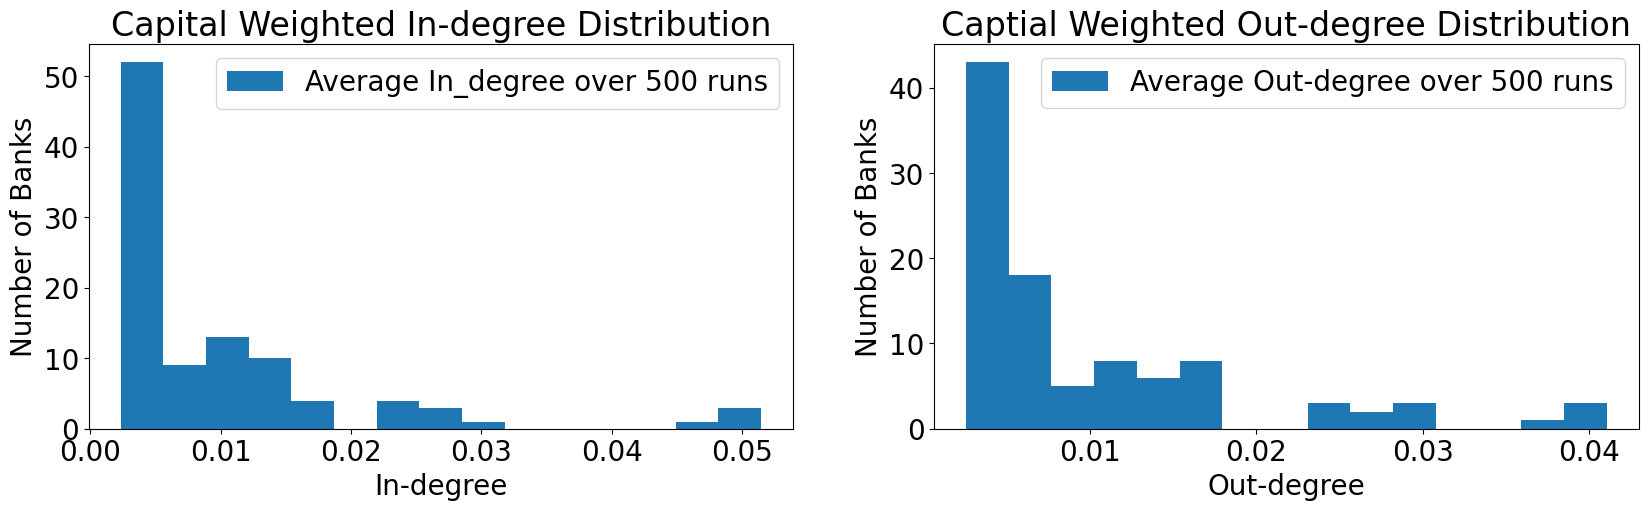

In [134]:
def plot_degree_distribution(t):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 5)
    ax1.set_title("Capital Weighted In-degree Distribution")
    ax1.hist(IndegreeCollection.mean(axis=0)[t], label="Average In_degree over 500 runs", bins=15)
    ax1.set_xlabel("In-degree")
    ax1.set_ylabel("Number of Banks")
    ax1.legend()

    ax2.set_title("Captial Weighted Out-degree Distribution")
    ax2.hist(OutdegreeCollection.mean(axis=0)[t], label="Average Out-degree over 500 runs", bins=15)
    ax2.set_xlabel("Out-degree")
    ax2.set_ylabel("Number of Banks")
    ax2.legend()
    plt.show()

plot_degree_distribution(100)

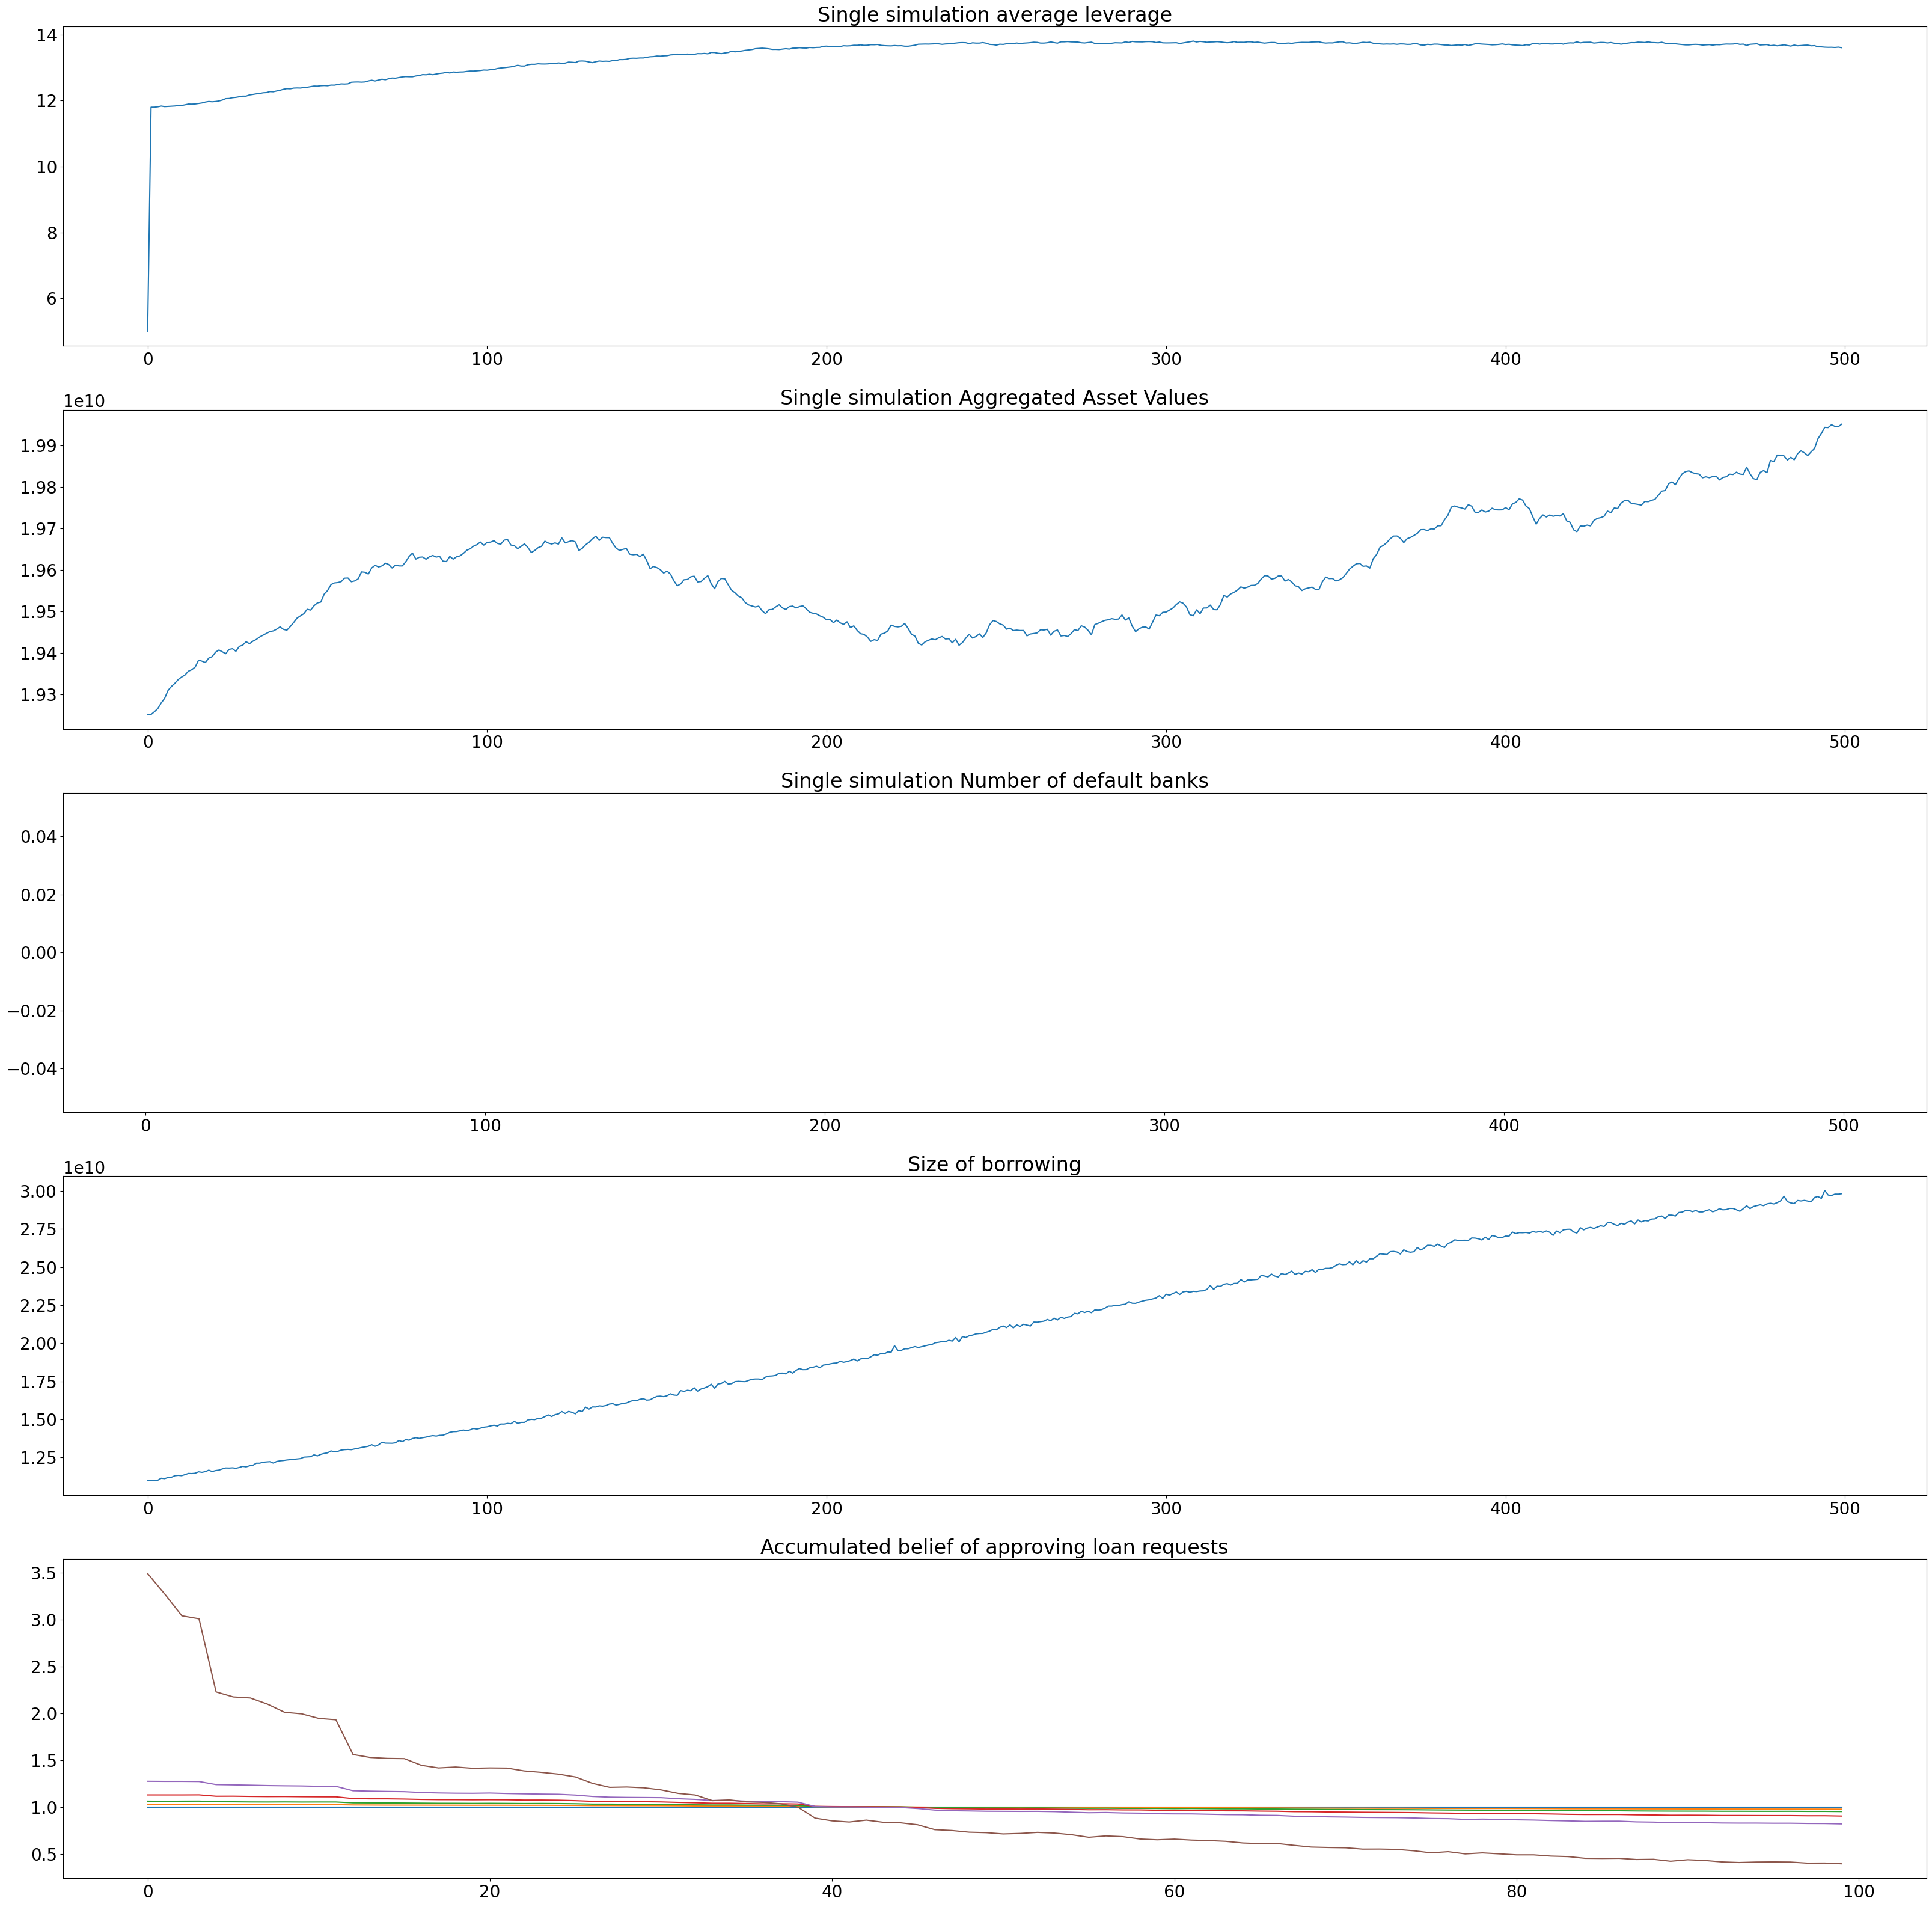

In [176]:
simulationMonitor(agent_data, model_data, simulationSteps)

In [98]:
def netWorkGraph(matrix, model, printLabel=True):
    size = model.N
    # Create a graph object with 5 nodes
    G = nx.DiGraph(seed=1)
    G.add_nodes_from(list(range(size)))
    # Create a list of edge weights
    weightedEdges = []
    for i in range(size):
        for j in range(size):
            if matrix[i][j] > 0.015:
                # direction of the edge is the direction of the money flow
                weightedEdges.append((j, i, matrix[i][j]))
    G.add_weighted_edges_from(weightedEdges)
    nodeSize = matrix.sum(axis=0) * 1000 
    bigLabelIndex = np.where(nodeSize >= np.percentile(nodeSize, 96))[0]
    bigLabel = [model.banks[i] if i in bigLabelIndex else "" for i in range(size)]
    # Set the labels for the nodes using a list of variables
    label_dict = {node: label for node, label in zip(G.nodes, bigLabel)}
    edges = G.edges()
    edgesWidth = [G[u][v]['weight'] * 5 for u,v in edges]
    # change the color of the center nodes
    node_colors = ['red' if node in bigLabelIndex else 'lightblue' for node in G.nodes()]
    pos = nx.fruchterman_reingold_layout(G, scale=10)
    nx.draw_networkx_nodes(G, pos, node_size=nodeSize,node_color=node_colors, alpha=0.9)
    if printLabel:
        label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
        nx.draw_networkx_labels(G, pos,labels = label_dict,
                                font_size=10, bbox=label_options)
    nx.draw_networkx_edges(G, pos, width=edgesWidth, alpha=0.5, connectionstyle="arc3,rad=0.05")
    plt.axis('off')
    plt.show()

In [99]:
# simulation and data collection
simulationSteps = 500
cMatrix = np.ones((100,100))*0.8
np.fill_diagonal(cMatrix, 1)
model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                leverageRatio = 20.0,                                     # leverage ratio upper bound for all banks
                depositReserve = 0.2,                                     # capital reserve as a ratio of portfolio value
                num_borrowing= 10,                                        # number of borrowing request per bank per step
                sizeOfBorrowing = 1.0,                                      # size of borrowing as a ratio of equity capital
                num_banks=100,                                            # number of banks in the system 
                alpha = 0.5,                                              # portfolio recovery rate                           
                beta = 0.9,                                               # interbank loan recovery rate
                fedRate = 0.04,                                            # interest rate on borrowing   
                portfolioReturnRate = 0.10,          
                # return rate on portfolio
                returnVolatiliy = 0.18,
                returnCorrelation = cMatrix,
                liquidityShockNum = 10,                                    # number of liquidity shocks per step      
                shockSize = 0.05,                                          # size of the shock
                shockDuration = [-1, -1]) # duration of the shock
                
model.datacollector.collect(model)
for _ in tqdm(range(simulationSteps)):
    model.simulate()
    
agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

100%|██████████| 500/500 [00:24<00:00, 20.75it/s]


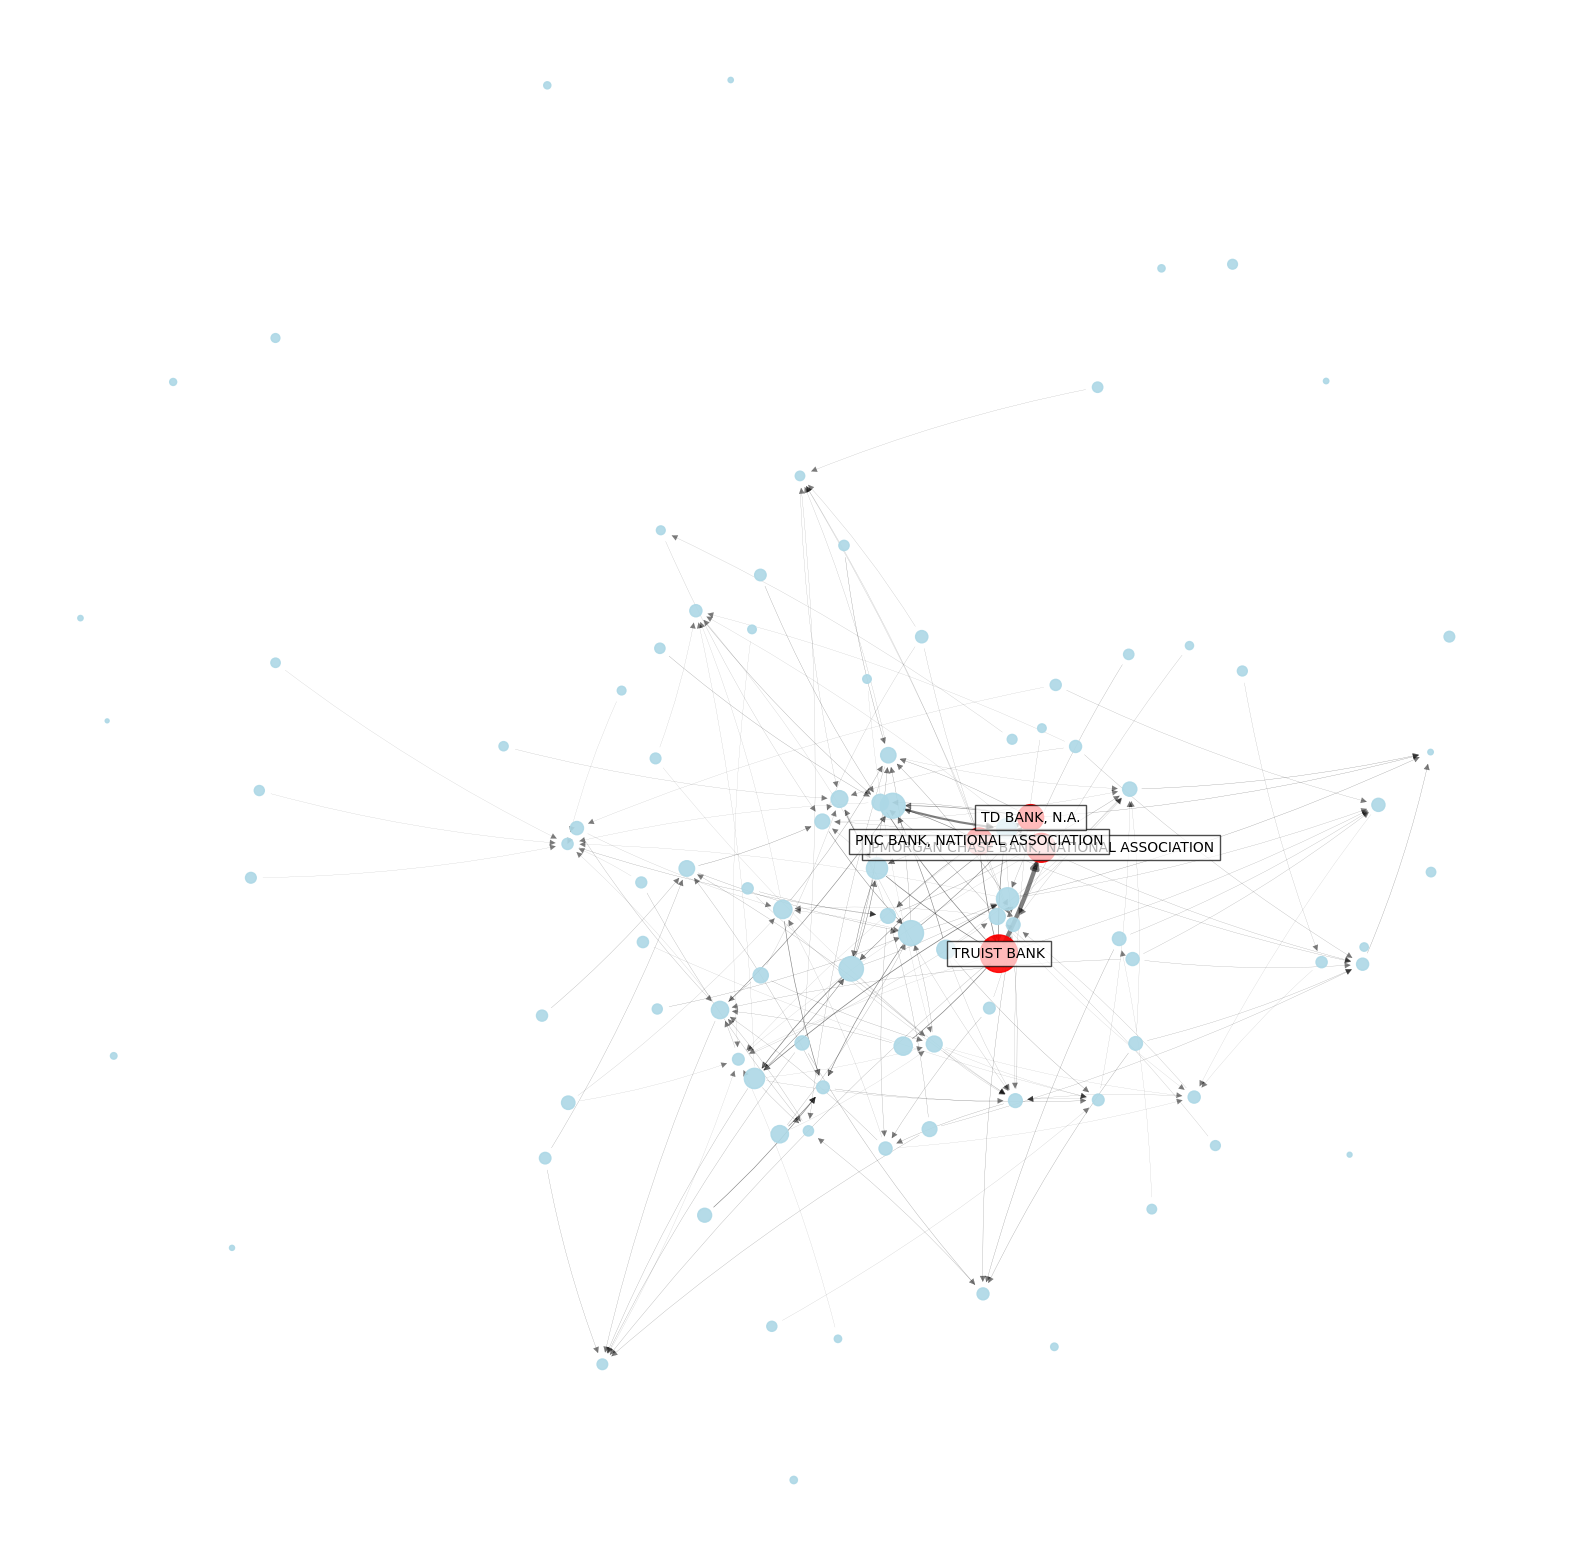

In [100]:
step = 0
netWorkGraph(model_data["Liability Matrix"][step]/model_data["Liability Matrix"][step].sum()*10, model, printLabel=True)

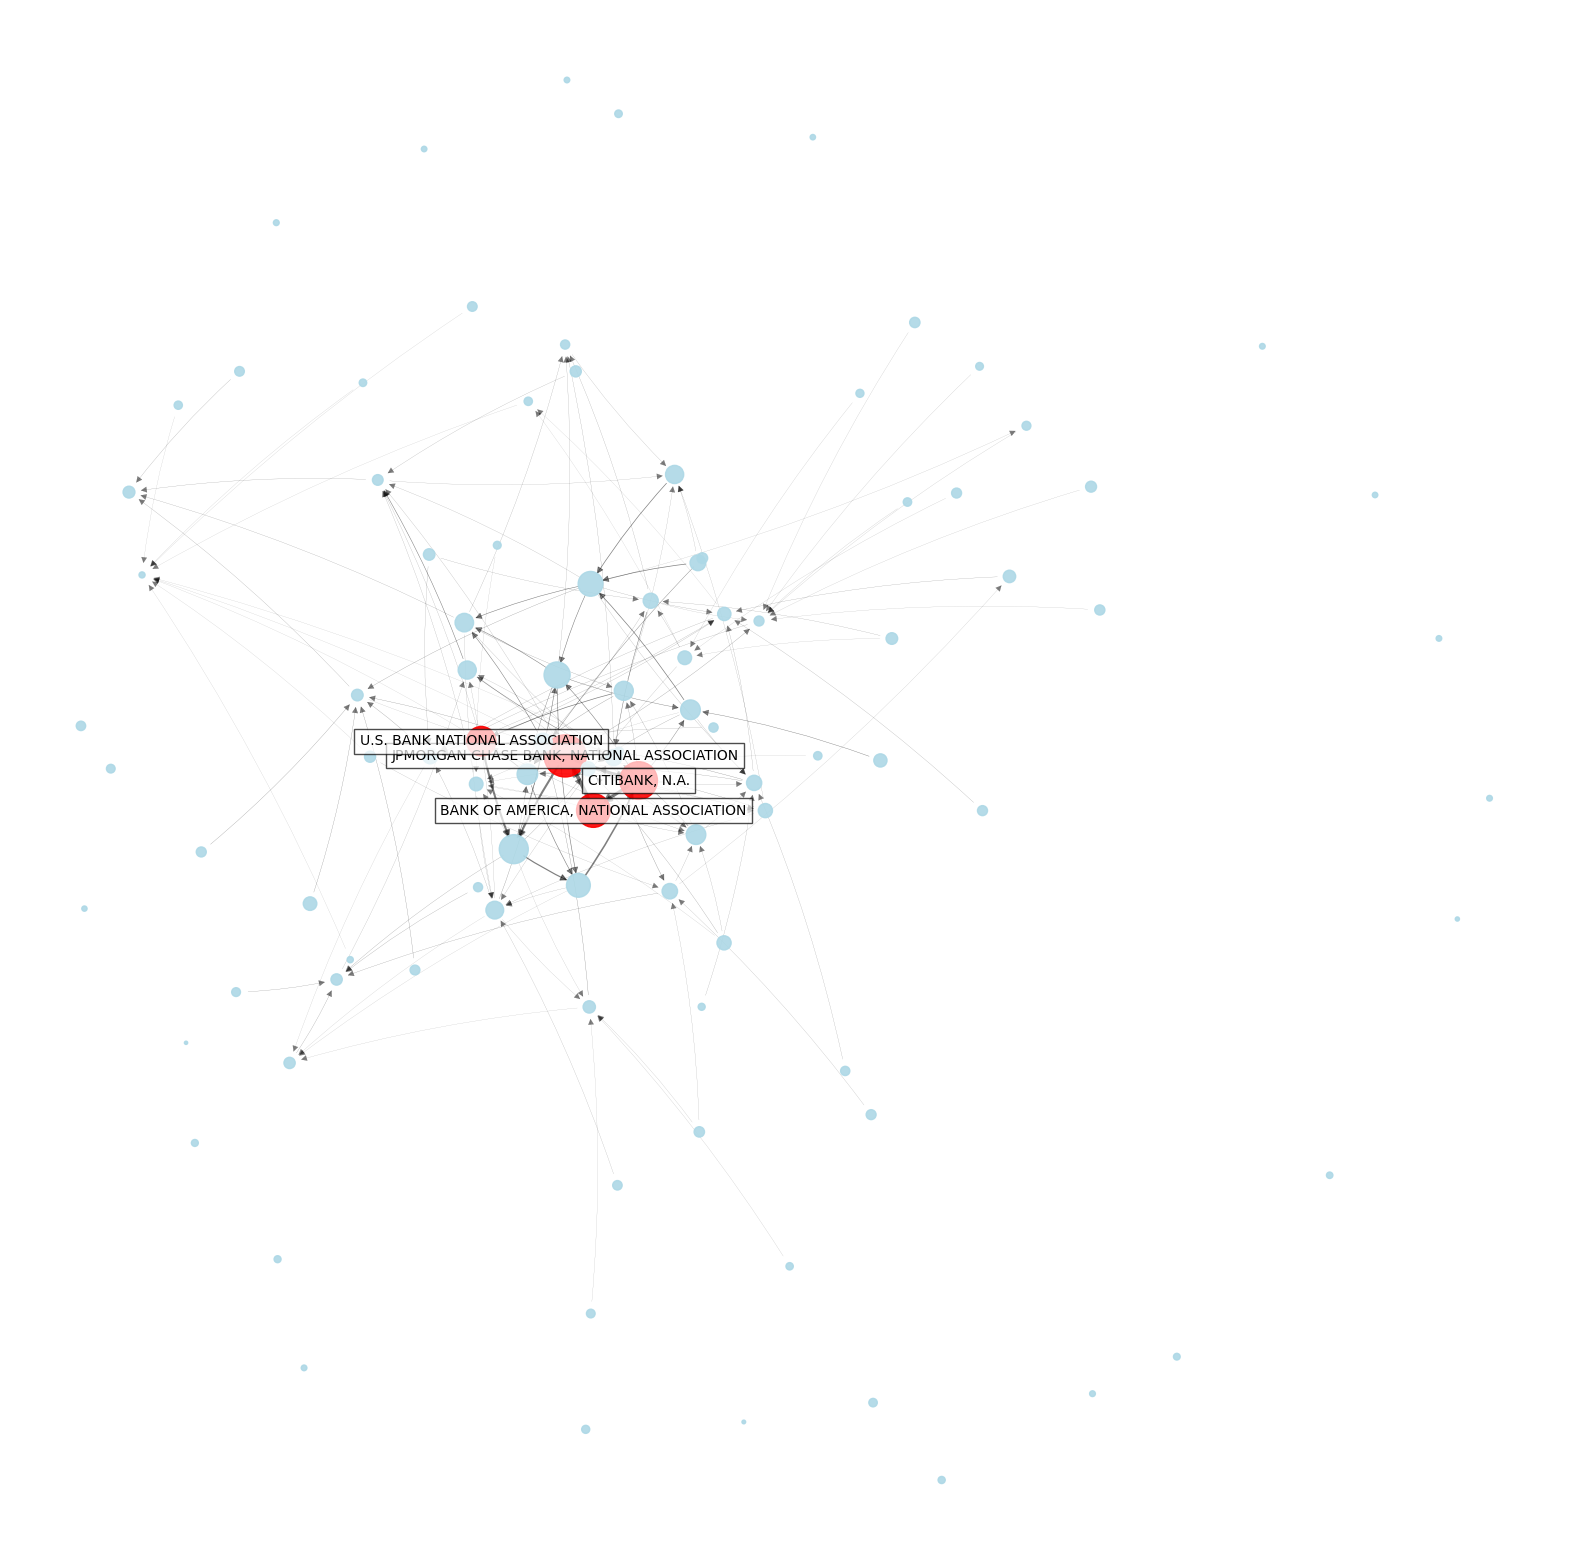

In [105]:
step = 100
netWorkGraph(model_data["Liability Matrix"][step]/model_data["Liability Matrix"][step].sum()*10, model, printLabel=True)

In [3]:
def run(iRun):
    np.random.seed(iRun)
    # simulation and data collection
    simulationSteps = 500
    cMatrix = np.ones((100,100))*0.8
    np.fill_diagonal(cMatrix, 1)
    model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                    leverageRatio = 20.0,                                     # leverage ratio upper bound for all banks
                    depositReserve = 0.2,                                     # capital reserve as a ratio of portfolio value
                    num_borrowing= 10,                                        # number of borrowing request per bank per step
                    sizeOfBorrowing = 1.0,                                      # size of borrowing as a ratio of equity capital
                    num_banks=100,                                            # number of banks in the system 
                    alpha = 0.5,                                              # portfolio recovery rate                           
                    beta = 0.9,                                               # interbank loan recovery rate
                    fedRate = 0.04,                                            # interest rate on borrowing   
                    portfolioReturnRate = 0.10,          
                    # return rate on portfolio
                    returnVolatiliy = 0.18,
                    returnCorrelation = cMatrix,
                    liquidityShockNum = 10,                                    # number of liquidity shocks per step      
                    shockSize = 0.05,                                          # size of the shock
                    shockDuration = [-1, -1]) # duration of the shock
                    
    model.datacollector.collect(model)
    for _ in range(simulationSteps):
        model.simulate()
        
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data = model.datacollector.get_model_vars_dataframe()
    return model_data, agent_data

In [155]:
import multiprocessing
# running the simulation in parallel
cpuNum = 48
numberOfruns = 500
results = []
batchNum = 0
while numberOfruns > 0:
    if numberOfruns > cpuNum:
        numberOfruns = numberOfruns - cpuNum
        with multiprocessing.Pool() as pool:
            # run the function in parallel on the input values
            results = results + pool.map(run, range(batchNum*cpuNum, (batchNum+1)*cpuNum))
        batchNum = batchNum + 1
    else:
        with multiprocessing.Pool() as pool:
            results = results + pool.map(run, range(batchNum*cpuNum, batchNum*cpuNum + numberOfruns))
        numberOfruns = 0

# calculate the average of the results
numberOfruns = len(results)
for iter in range(numberOfruns):
    if iter % 10 == 0:
        print(iter)
    m, a = results[iter]
    a.Default = a.Default.map({True: 1, False: 0})
    if iter == 0:
        model_data = m
        agent_data = a
    else:
        model_data += m
        agent_data += a

model_data = model_data/numberOfruns
agent_data = agent_data/numberOfruns

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


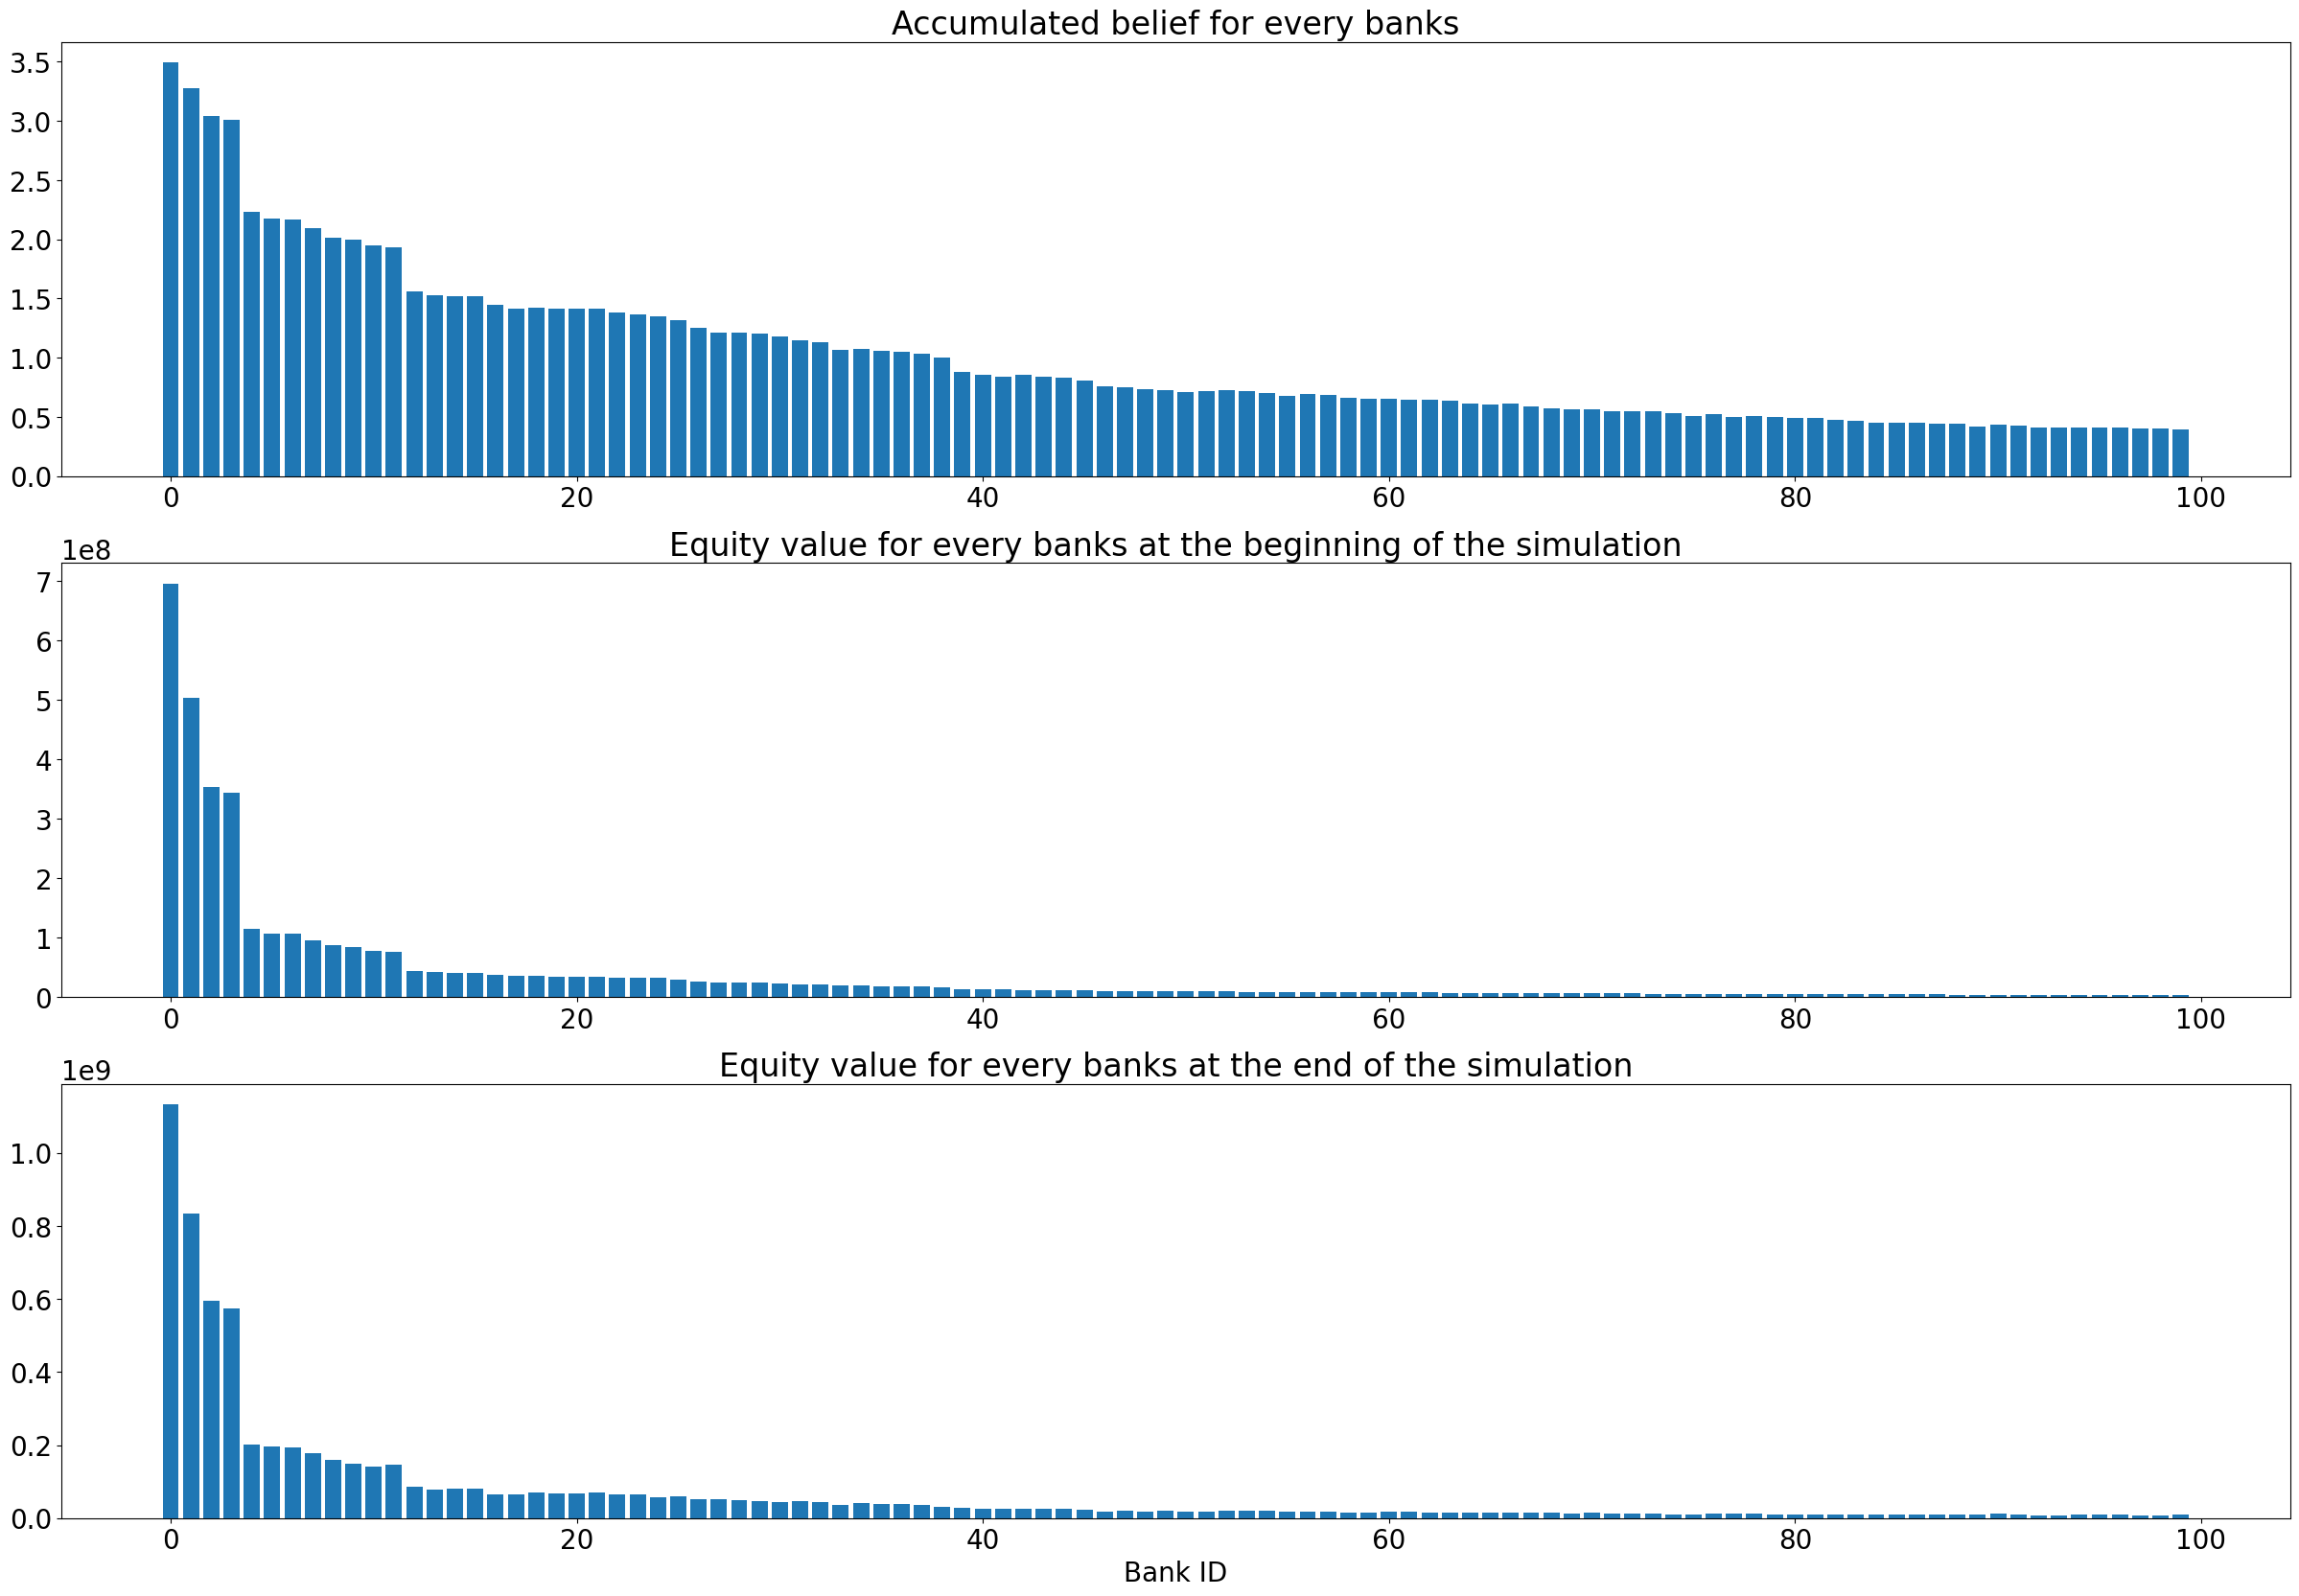

In [175]:
# bar chart of portfolio value
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(30, 20)
ax1.bar(range(100), model_data["Trust Matrix"][simulationSteps].sum(axis = 0))
ax1.set_title("Accumulated belief for every banks")
ax2.bar(range(100), agent_data.xs(0, level="Step")["Equity"])
ax2.set_title("Equity value for every banks at the beginning of the simulation")
ax3.bar(range(100), agent_data.xs(500, level="Step")["Equity"])
ax3.set_title("Equity value for every banks at the end of the simulation")
ax3.set_xlabel("Bank ID")
plt.show()